# Mapping Police Violence

## Reading Point data

In [1]:
# %matplotlib widget
%matplotlib notebook


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

PID_Table = pd.read_csv('https://raw.githubusercontent.com/Police-Involved-Deaths-CA/Data/main/Spatial_Data/Geocoded_Points_not_Complete/PID_locations.csv')
PID_Table

,date,INDEX,id_victim,first_name,last_name,middle_name,age,gender,race,prov,...,Type,Demographic,GC,GC_City_Only,latitude,longitude,geocoding_attempt,geocoding_return,geocoding_notes,geocode_city
0,2000-01-05,235,235_KCC,Paul,Murdock,NaN,25.0,NaN,Not Specified,ON,...,Police Involved Death,Not Specified,True,True,43.653482,-79.383935,Toronto ON,"Toronto, Ontario, Canada",Passed,Toronto
1,2000-01-19,236,236_KCC,Lloyd,Dustyhorn,NaN,53.0,Male,Indigenous,SK,...,Police Killing,Indigenous,True,True,52.131802,-106.660767,Saskatoon SK,"Saskatoon, Saskatchewan, Canada",Passed,Saskatoon
2,2000-01-29,237,237_KCC,Rodney,Naitus,NaN,25.0,Male,Indigenous,SK,...,Police Killing,Indigenous,True,True,52.131802,-106.660767,Saskatoon SK,"Saskatoon, Saskatchewan, Canada",Passed,Saskatoon
3,2000-01-30,238,0413_V1,Stuart,Mitchell,NaN,49.0,Male,Not Specified,ON,...,Police Killing,Not Specified,True,False,43.658858,-79.365514,Winchester & Parliament Toronto ON,"Parliament Street, Toronto, Ontario M5A 2Z6, C...",Passed,Toronto
4,2000-02-03,239,239_KCC,Lawrence,Wegner,NaN,30.0,Male,Indigenous,SK,...,Police Killing,Indigenous,True,True,52.131802,-106.660767,Saskatoon SK,"Saskatoon, Saskatchewan, Canada",Passed,Saskatoon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841,2013-02-15,1396,MS_24,Lena,Anderson,NaN,NaN,Female,Indigenous,ON,...,Police Involved Death,Indigenous,True,True,53.533855,-88.607805,Kasabonika Lake First Nation ON,"Kasabonika Lake, Ontario, Canada",Passed,Kasabonika Lake
842,2019-12-29,1397,MS_25,NaN,NaN,NaN,32.0,Male,Not Specified,AB,...,Police Killing,Not Specified,True,True,52.669601,-111.309379,Hardisty AB,"Hardisty, Alberta, Canada",Passed,Hardisty
843,2020-10-08,1399,MS_27,Jackson,Diggle,NaN,17.0,Male,Not Specified,BC,...,Police Killing,Not Specified,True,False,49.160000,-122.780000,Fleetwood Surrey BC,"Fleetwood, Surrey, British Columbia, Canada",Passed,Surrey
844,2016-02-26,1400,MS_28,Michael,Ryan,NaN,38.0,Male,White,SK,...,Police Involved Death,White,True,False,52.129631,-106.699557,22nd St Saskatoon SK,"22nd Street West, Saskatoon, Saskatchewan S7M ...",Passed,Saskatoon


# Parse the Data & convert to a Geodataframe

<IPython.core.display.Javascript object>


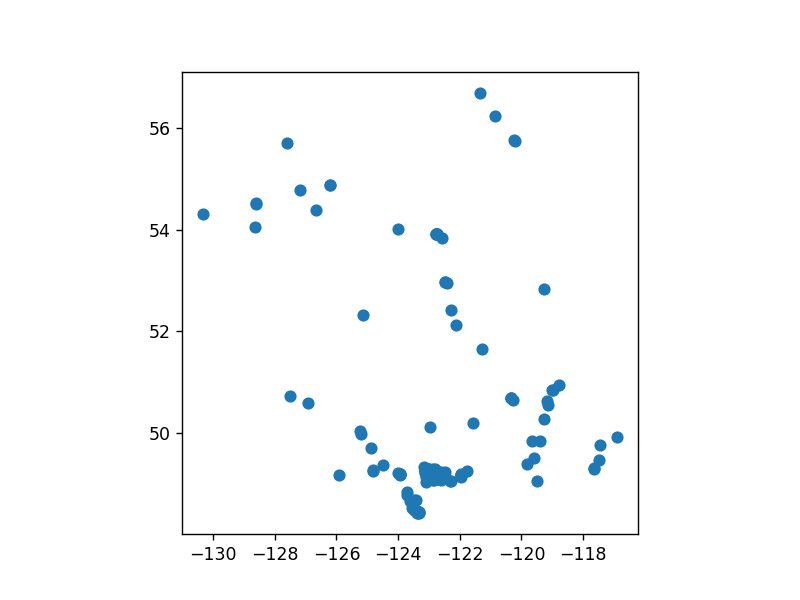

,date,INDEX,id_victim,first_name,last_name,middle_name,age,gender,race,prov,...,Demographic,GC,GC_City_Only,latitude,longitude,geocoding_attempt,geocoding_return,geocoding_notes,geocode_city,geometry
10,2000-08-21,250,0267_V1,Mladen,Cujko,NaN,33.0,Male,Not Specified,BC,...,Not Specified,True,False,48.510812,-123.549401,Trans Canada Hwy Langford (Western Communities...,"Trans-Canada Highway, British Columbia V0R 2W3...",Passed,Trans-Canada Highway,POINT (-123.54940 48.51081)
25,2002-05-12,303,0266_V1,Paulsey,Alphonse,NaN,67.0,Male,Indigenous,BC,...,Indigenous,True,False,52.129092,-122.135499,730 Oliver St. Williams Lake BC,"730 Oliver Street, Williams Lake, British Colu...",Passed,Williams Lake,POINT (-122.13550 52.12909)
28,2002-08-01,309,0269_V1,Jeffrey,Berg,Michael,37.0,Male,White,BC,...,White,True,False,49.241317,-123.052770,4800 Slocan St. Vancouver BC,"4800 Slocan Street, Vancouver, British Columbi...",Passed,Vancouver,POINT (-123.05277 49.24132)
33,2002-09-27,317,0479_V1,Darrell,Paquette,Raymond,43.0,Male,Not Specified,BC,...,Not Specified,True,False,53.909967,-122.758714,1600 15th Ave Prince George BC,"1600 15th Avenue, Prince George, British Colum...",Passed,Prince George,POINT (-122.75871 53.90997)
34,2002-12-07,321,0270_V1,Ben,Matson,Robert,49.0,Male,Not Specified,BC,...,Not Specified,True,False,49.276509,-123.125191,600 Davie St. Vancouver BC,"600 Davie Street, Vancouver, British Columbia ...",Passed,Vancouver,POINT (-123.12519 49.27651)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,2003-01-01,1389,MS_15,Joey,Peters,NaN,NaN,Male,Indigenous,BC,...,Indigenous,True,True,49.691951,-124.868799,Comox BC,"Point Holmes Lookout, Comox, British Columbia ...",Passed,Comox,POINT (-124.86880 49.69195)
836,2003-01-01,1390,MS_16,Frank,Watts,NaN,NaN,Male,Indigenous,BC,...,Indigenous,True,True,54.312657,-130.325490,Prince Rupert BC,"Prince Rupert, British Columbia, Canada",Passed,Prince Rupert,POINT (-130.32549 54.31266)
839,2009-12-09,1394,MS_22,Johhny,Dawson,Bingo,NaN,Male,Indigenous,BC,...,Indigenous,True,False,49.281997,-123.098235,238 E Cordova St Vancouver BC,"238 East Cordova Street, Vancouver, British Co...",Passed,Vancouver,POINT (-123.09824 49.28200)
840,2011-08-15,1395,MS_23,Lynn,Kalmring,NaN,55.0,Female,White,BC,...,White,True,True,49.494891,-119.594421,Penticton BC,"Penticton, British Columbia, Canada",Passed,Penticton,POINT (-119.59442 49.49489)


In [2]:
PID_BC = PID_Table.loc[PID_Table['prov']=='BC']
PID_BC = gpd.GeoDataFrame(
                    PID_BC,
                    geometry=gpd.points_from_xy(PID_BC.longitude, PID_BC.latitude),
                    crs='WGS1984'
                        )

PID_BC.plot()
PID_BC

## Read the Census Data, Re-project the points

To GeoJSON data, we just need to specify the driver.

<IPython.core.display.Javascript object>


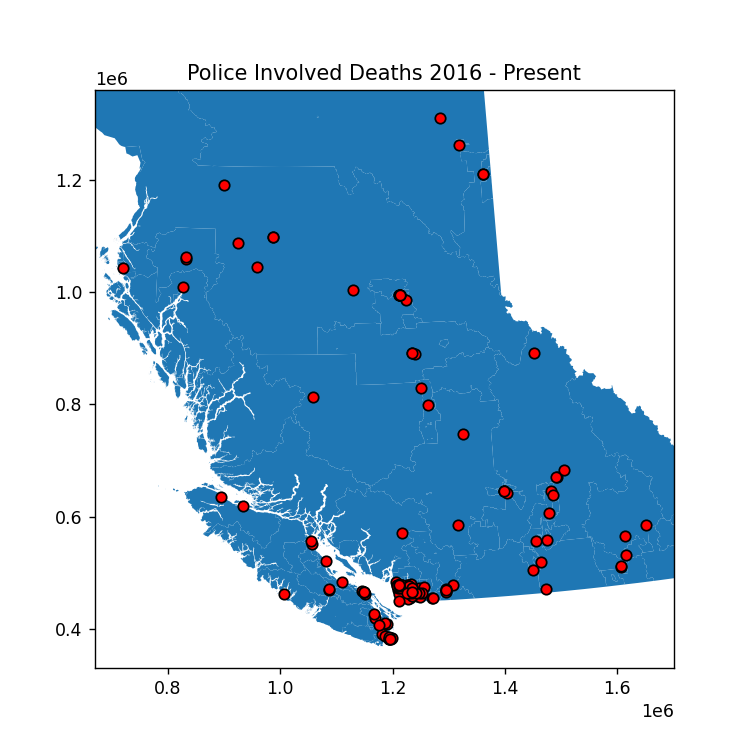

Text(0.5, 1.0, 'Police Involved Deaths 2016 - Present')

In [3]:
BC_FSA = gpd.read_file("data/Outputs/BC_FSA_Clip.json", driver = "GeoJSON")

BC_FSA.crs

PID_BC = PID_BC.to_crs(BC_FSA.crs)

fig,ax=plt.subplots(figsize=(6,6))
BC_FSA.plot(ax=ax)
PID_BC.plot(ax=ax,color='r',edgecolor='k')


ax.set_ylim(PID_BC.geometry.y.min()-5e4,PID_BC.geometry.y.max()+5e4)
ax.set_xlim(PID_BC.geometry.x.min()-5e4,PID_BC.geometry.x.max()+5e4)
ax.set_title('Police Involved Deaths 2016 - Present')

# Vector Overlay


Lets import a points layer for some locations in BC and walk through a handful of vector overlay methods.


## Spatial Joins

We can use a [spatial join](https://geopandas.org/gallery/spatial_joins.html) to merge attributes between two layers based on location

<IPython.core.display.Javascript object>


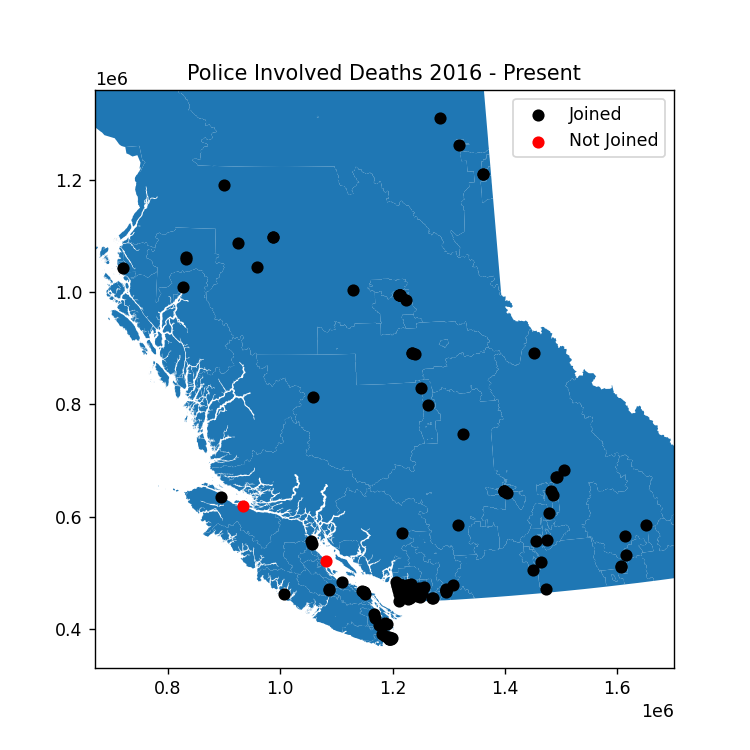

Not Joined:  2


,date,INDEX,id_victim,first_name,last_name,middle_name,age,gender,race,prov,...,geocoding_return,geocoding_notes,geocode_city,geometry,index_right,spatial_id,name_right,Population,Pop_Density,Community_Type
37,2003-02-28,327,0274_V1,Lorraine,Moon,Sue,40.0,Female,Indigenous,BC,...,"Alert Bay BC, British Columbia V0N 1A0, Canada",Passed,Alert Bay BC,POINT (934136.650 619545.678),NaN,NaN,NaN,NaN,NaN,NaN
835,2003-01-01,1389,MS_15,Joey,Peters,NaN,NaN,Male,Indigenous,BC,...,"Point Holmes Lookout, Comox, British Columbia ...",Passed,Comox,POINT (1081646.231 520179.550),NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
fig,ax=plt.subplots(figsize=(6,6))

# Changin how to "right" will significantly increase the runtime
# and duplicate each province multiple times (once for each incident within it)
Test_Join = gpd.sjoin(PID_BC, BC_FSA, how="left") 


BC_FSA.plot(ax=ax)
## See if there are any locations "outside" the provincial boundaries
Test_Join.loc[Test_Join['name_right'].isnull()==False].plot(ax=ax,color='k',label='Joined')
Test_Join.loc[Test_Join['name_right'].isnull()].plot(ax=ax,color='r',label='Not Joined')

ax.legend()

Out = Test_Join.loc[Test_Join['name_right'].isnull()]

ax.set_ylim(PID_BC.geometry.y.min()-5e4,PID_BC.geometry.y.max()+5e4)
ax.set_xlim(PID_BC.geometry.x.min()-5e4,PID_BC.geometry.x.max()+5e4)
ax.set_title('Police Involved Deaths 2016 - Present')

print('Not Joined: ',Test_Join.loc[Test_Join['name_right'].isnull()].count()['INDEX'])

# Test_Join.head()
Test_Join.loc[Test_Join['name_right'].isnull(),]

# Try again

* Lets import the "unclipped" FSA file, so we can include the two points that are in the "ocean"

<IPython.core.display.Javascript object>


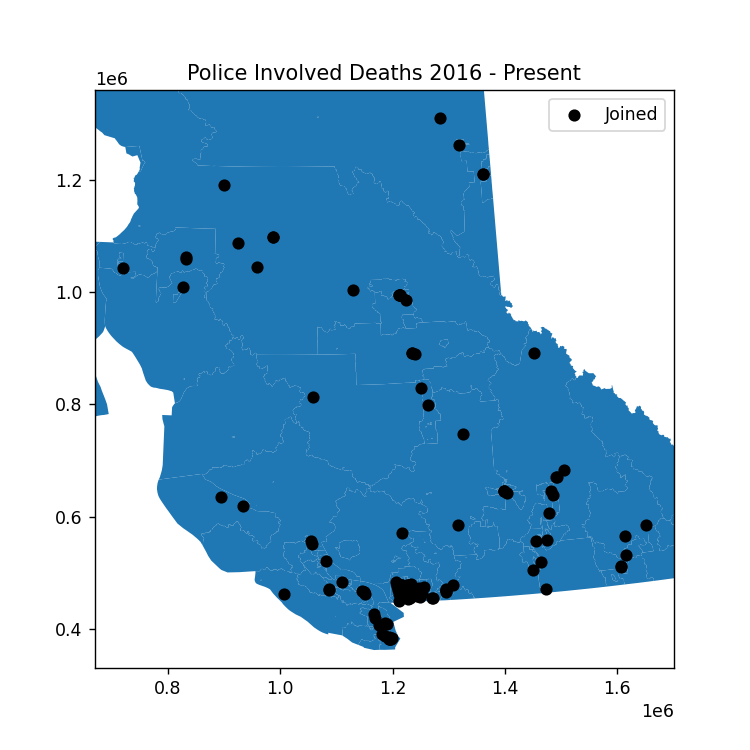

C:\Users\User\.conda\envs\geo-env\lib\site-packages\geopandas\plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


Not Joined:  0


,date,INDEX,id_victim,first_name,last_name,middle_name,age,gender,race,prov,...,longitude,geocoding_attempt,geocoding_return,geocoding_notes,geocode_city,geometry,index_right,spatial_id,name_right,Population
10,2000-08-21,250,0267_V1,Mladen,Cujko,NaN,33.0,Male,Not Specified,BC,...,-123.549401,Trans Canada Hwy Langford (Western Communities...,"Trans-Canada Highway, British Columbia V0R 2W3...",Passed,Trans-Canada Highway,POINT (1181389.088 391462.503),172,V9E,"V9E, BC (FSA)",5309.0
25,2002-05-12,303,0266_V1,Paulsey,Alphonse,NaN,67.0,Male,Indigenous,BC,...,-122.135499,730 Oliver St. Williams Lake BC,"730 Oliver Street, Williams Lake, British Colu...",Passed,Williams Lake,POINT (1263993.164 798105.663),42,V2G,"V2G, BC (FSA)",20475.0
28,2002-08-01,309,0269_V1,Jeffrey,Berg,Michael,37.0,Male,White,BC,...,-123.052770,4800 Slocan St. Vancouver BC,"4800 Slocan Street, Vancouver, British Columbi...",Passed,Vancouver,POINT (1214753.211 473912.281),106,V5R,"V5R, BC (FSA)",50592.0
33,2002-09-27,317,0479_V1,Darrell,Paquette,Raymond,43.0,Male,Not Specified,BC,...,-122.758714,1600 15th Ave Prince George BC,"1600 15th Avenue, Prince George, British Colum...",Passed,Prince George,POINT (1212359.605 994424.810),46,V2L,"V2L, BC (FSA)",10944.0
34,2002-12-07,321,0270_V1,Ben,Matson,Robert,49.0,Male,Not Specified,BC,...,-123.125191,600 Davie St. Vancouver BC,"600 Davie Street, Vancouver, British Columbia ...",Passed,Vancouver,POINT (1209320.364 477602.288),115,V6B,"V6B, BC (FSA)",36582.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,2003-01-01,1389,MS_15,Joey,Peters,NaN,NaN,Male,Indigenous,BC,...,-124.868799,Comox BC,"Point Holmes Lookout, Comox, British Columbia ...",Passed,Comox,POINT (1081646.231 520179.550),178,V9M,"V9M, BC (FSA)",19938.0
836,2003-01-01,1390,MS_16,Frank,Watts,NaN,NaN,Male,Indigenous,BC,...,-130.325490,Prince Rupert BC,"Prince Rupert, British Columbia, Canada",Passed,Prince Rupert,POINT (719428.312 1043081.336),155,V8J,"V8J, BC (FSA)",13207.0
839,2009-12-09,1394,MS_22,Johhny,Dawson,Bingo,NaN,Male,Indigenous,BC,...,-123.098235,238 E Cordova St Vancouver BC,"238 East Cordova Street, Vancouver, British Co...",Passed,Vancouver,POINT (1211256.999 478291.651),114,V6A,"V6A, BC (FSA)",23218.0
840,2011-08-15,1395,MS_23,Lynn,Kalmring,NaN,55.0,Female,White,BC,...,-119.594421,Penticton BC,"Penticton, British Columbia, Canada",Passed,Penticton,POINT (1463701.758 518614.328),38,V2A,"V2A, BC (FSA)",40402.0


In [5]:
BC_FSA_Albers = gpd.read_file('data/Outputs/BC_FSA_Albers.shp')

fig,ax=plt.subplots(figsize=(6,6))

# Changin how to "right" will significantly increase the runtime
# and duplicate each province multiple times (once for each incident within it)
Test_Join = gpd.sjoin(PID_BC, BC_FSA_Albers, how="left") 

BC_FSA_Albers.plot(ax=ax)
## See if there are any locations "outside" the provincial boundaries
Test_Join.loc[Test_Join['name_right'].isnull()==False].plot(ax=ax,color='k',label='Joined')
Test_Join.loc[Test_Join['name_right'].isnull()].plot(ax=ax,color='r',label='Not Joined')

ax.legend()

Out = Test_Join.loc[Test_Join['name_right'].isnull()]

ax.set_ylim(PID_BC.geometry.y.min()-5e4,PID_BC.geometry.y.max()+5e4)
ax.set_xlim(PID_BC.geometry.x.min()-5e4,PID_BC.geometry.x.max()+5e4)
ax.set_title('Police Involved Deaths 2016 - Present')

print('Not Joined: ',Test_Join.loc[Test_Join['name_right'].isnull()].count()['INDEX'])

# Test_Join.head()
Test_Join.loc[Test_Join['name_right'].isnull()==False]

## Point In Polygon Analysis

The spatial join method is useful in some cases, but for others, it produces a lot of redundancy.  If your goal is to calculate the number of points per polygon, we can do a point in polygon analysis using the [.within()](https://geopandas.org/docs/reference/api/geopandas.GeoSeries.within.html#geopandas.GeoSeries.within) method. 

* We're going to "cheat" a bit here.  We can use the "unclipped layer" because it's less complicated (fewer vertices).
* It has the same index as the clipped layer, so we can add the points total to the layer we want to display.

In [6]:
BC_FSA['Deaths'] = 0.0
for i,row in BC_FSA_Albers.iterrows():
#     print(i)
    pip = PID_BC.within(row['geometry'])
#     print(pip)
    if pip.sum()>0:
        BC_FSA.loc[BC_FSA.index==i,'Deaths']+=pip.sum()
print(BC_FSA['Deaths'].describe())

count    189.000000
mean       0.841270
std        1.319329
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        9.000000
Name: Deaths, dtype: float64


# Masking

* Make a column to differentiate between the FSA with zero incidents

In [7]:
BC_FSA['Mask']=0
BC_FSA.loc[BC_FSA['Deaths']<1,'Mask']=1

print(BC_FSA.groupby('Mask').count()['spatial_id'])

Mask
0     88
1    101
Name: spatial_id, dtype: int64


<IPython.core.display.Javascript object>


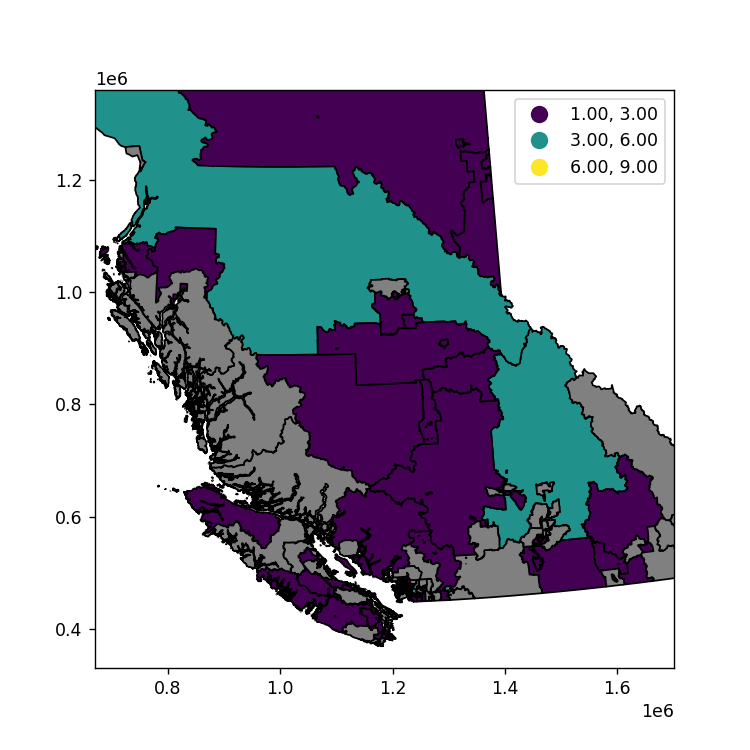

(669428.3115716075, 1701532.9841610992)

In [8]:
fig,ax=plt.subplots(figsize=(6,6))
BC_FSA.loc[BC_FSA['Mask']==0].plot(column='Deaths',ax=ax,legend=True,scheme="User_Defined", 
         classification_kwds=dict(bins=[3,6,
             BC_FSA['Deaths'].max()]),
                    edgecolor='k')
BC_FSA.loc[BC_FSA['Mask']==1].plot(ax=ax,color='grey',edgecolor='k')

ax.set_ylim(PID_BC.geometry.y.min()-5e4,PID_BC.geometry.y.max()+5e4)
ax.set_xlim(PID_BC.geometry.x.min()-5e4,PID_BC.geometry.x.max()+5e4)

# Calculating the Death Rate

<IPython.core.display.Javascript object>


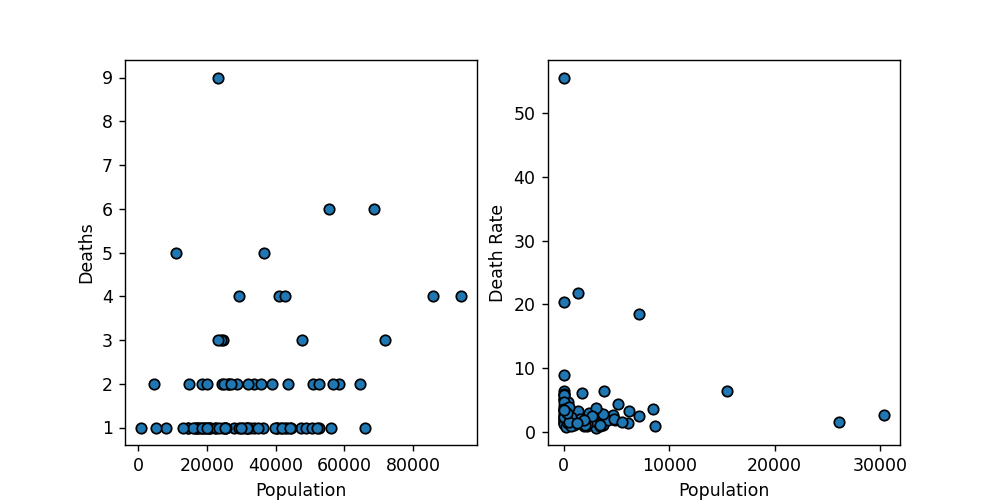

Text(0.5, 0, 'Population')

In [9]:
BC_FSA['Death_Rate']=BC_FSA['Deaths']/BC_FSA['Population']*1e6/21
BC_FSA['Death_Rate']=BC_FSA['Death_Rate'].fillna(0)

fig,ax=plt.subplots(1,2,figsize = (8,4))

Deaths = BC_FSA.loc[BC_FSA['Mask']==0]

ax[0].scatter(Deaths['Population'],Deaths['Deaths'],edgecolor='k')
ax[0].set_ylabel('Deaths')
ax[0].set_xlabel('Population')


ax[1].scatter(Deaths['Pop_Density'],Deaths['Death_Rate'],edgecolor='k')
ax[1].set_ylabel('Death Rate')
ax[1].set_xlabel('Population')


# Outliers

<IPython.core.display.Javascript object>


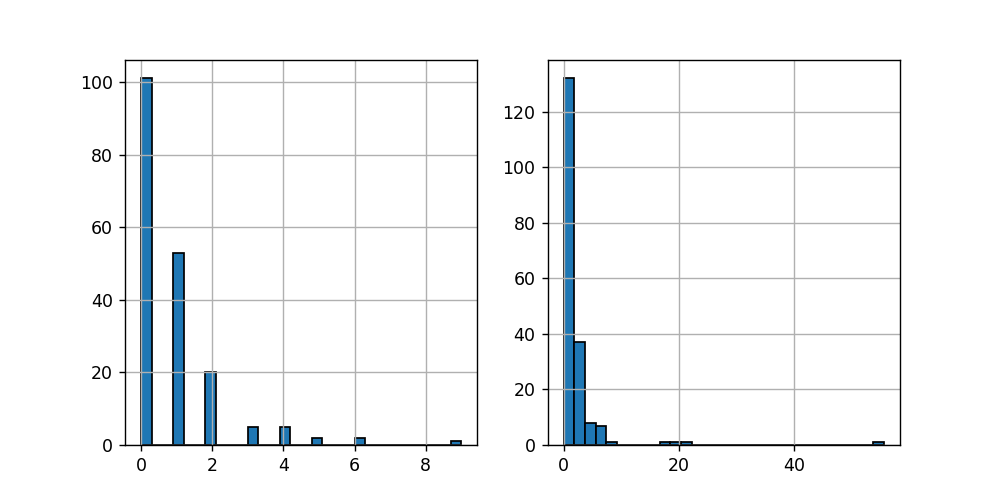

              name  Population  Pop_Density  Deaths  Death_Rate
135  V7B, BC (FSA)       857.0    36.773975     1.0   55.564816
              name  Population  Pop_Density  Deaths  Death_Rate
114  V6A, BC (FSA)     23218.0  7133.672449     9.0   18.458585


In [10]:


fig,ax=plt.subplots(1,2,figsize=(8,4))
BC_FSA['Deaths'].hist(ax=ax[0],bins=30,edgecolor='k')
BC_FSA['Death_Rate'].hist(ax=ax[1],bins=30,edgecolor='k')

print(BC_FSA.loc[BC_FSA['Death_Rate']==BC_FSA['Death_Rate'].max(),
                ['name','Population','Pop_Density','Deaths','Death_Rate']])
print(BC_FSA.loc[BC_FSA['Deaths']==BC_FSA['Deaths'].max(),
                ['name','Population','Pop_Density','Deaths','Death_Rate']])


# Mapping Deaths per FSA

We can classify our data into bins and specify a [colormap](https://colorbrewer2.org/#type=sequential&scheme=OrRd&n=3)
* How would we change this code to to map the death rate instead?

<IPython.core.display.Javascript object>


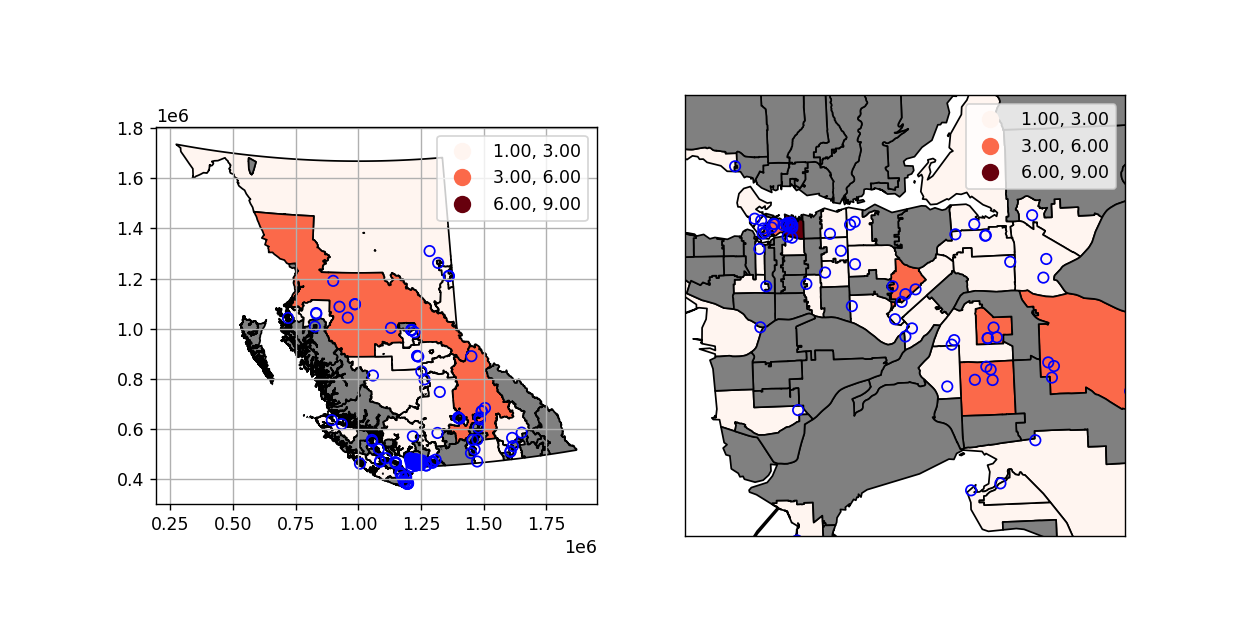

In [54]:
Varriable = 'Deaths'
Class_Map ={
    'bins':[3,6,BC_FSA[Varriable].max()]
}

fig,ax=plt.subplots(1,2,figsize=(10,5))

BC_FSA.loc[BC_FSA['Mask']==0].plot(column=Varriable,ax=ax[0],legend=True,scheme="User_Defined", 
         classification_kwds=Class_Map,cmap='Reds',edgecolor='k')

BC_FSA.loc[BC_FSA['Mask']==1].plot(ax=ax[0],color='grey',edgecolor='k')

PID_BC.plot(ax=ax[0],facecolor='None'
            ,edgecolor='blue')

ax[0].grid()

BC_FSA.loc[BC_FSA['Mask']==0].plot(column=Varriable,ax=ax[1],legend=True,scheme="User_Defined", 
         classification_kwds=Class_Map,cmap='Reds',edgecolor='k')

BC_FSA.loc[BC_FSA['Mask']==1].plot(ax=ax[1],color='grey',edgecolor='k')

PID_BC.plot(ax=ax[1],facecolor='None'
            ,edgecolor='blue')

# ## Set Zoom and turn axes off
x = 1.222e6
y = 0.47e6

Size = 4e4
v = Size/2
h = Size/2

ax[1].set_xlim(x-h,x+h)
ax[1].set_ylim(y-h,y+h)

ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)


## Kernel Density

* Kernel Density is a spatial interpolation method, we can use to map the probability of police involved deaths over space

0.0 0.0002464680156817652 2.8127469336002427e-07 0.9767601256558874


<IPython.core.display.Javascript object>


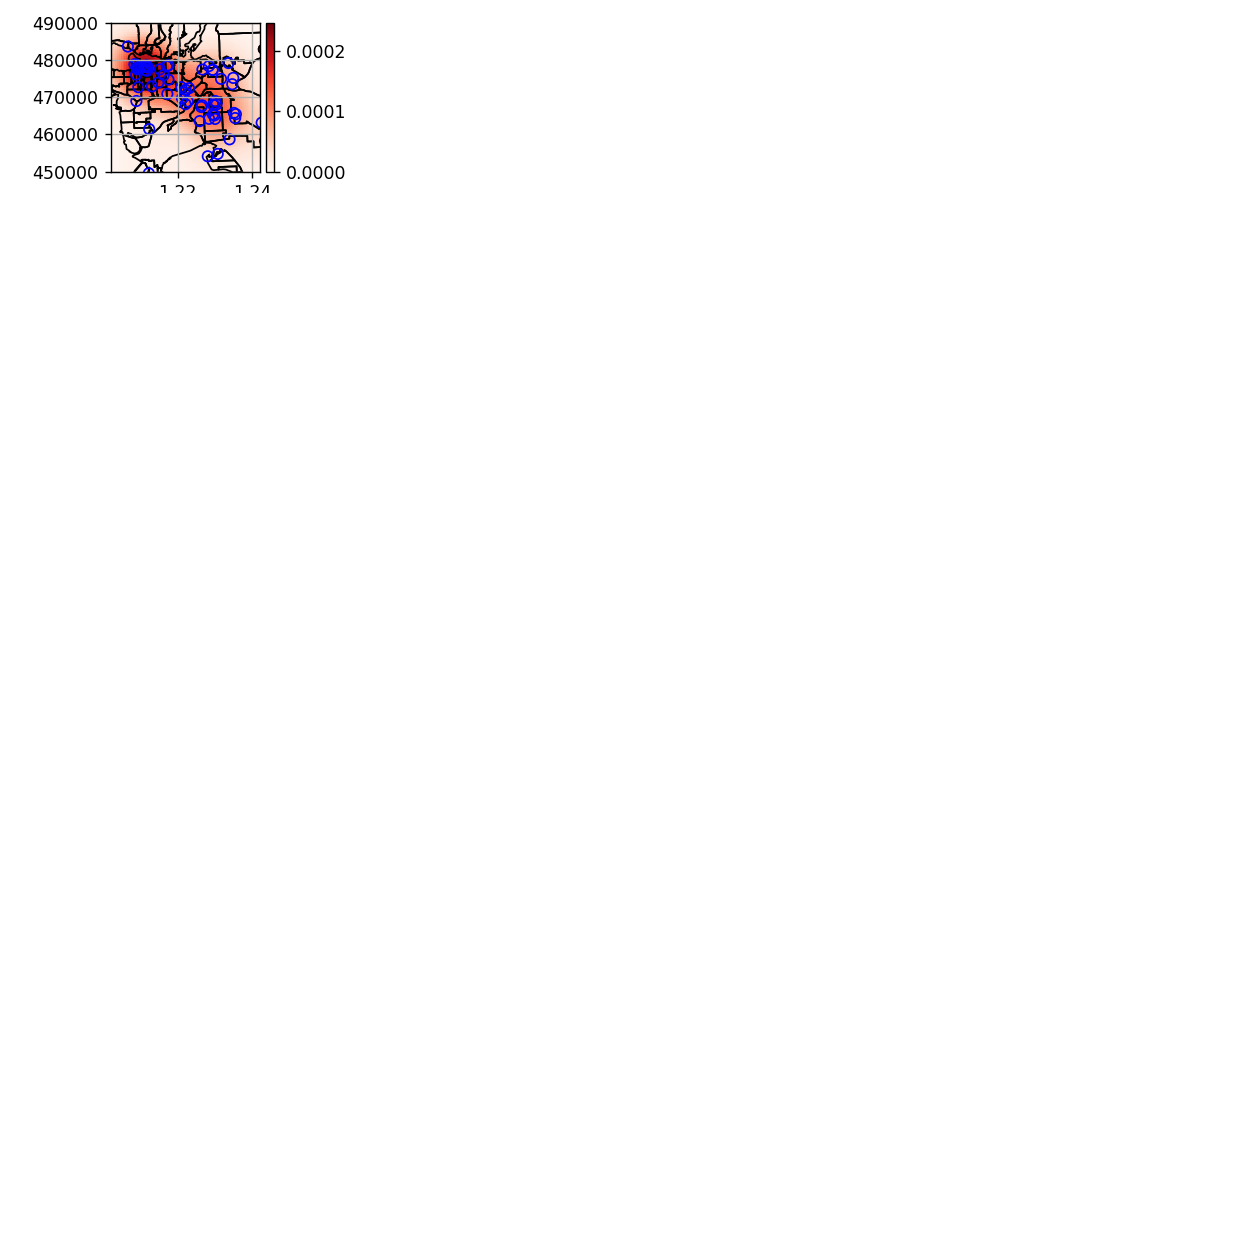

In [55]:
from sklearn.neighbors import KernelDensity
import pandas as pd
import geopandas as gpd
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import rasterio as rio
from rasterio.plot import show

def kde2D(x, y, bandwidth, cell_size=1e3, **kwargs): 
    """Build 2D kernel density estimate (KDE)."""
    # Transform ipnut points to x,y pairs
    xy_train  = np.vstack([y, x]).T
    # Fit the kernel density model
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(xy_train)

    """Construct the Output Image"""
    # Our "Null" hypothesis is a uniform 2D distribution - create a 2D grid
    # Subtract/Add the cell size to the min/max the intervals are fully inclusive of the feature space
    x_ax = np.arange(x.min()-cell_size,x.max()+cell_size,cell_size)
    y_ax = np.arange(y.min()-cell_size,y.max()+cell_size,cell_size)
    xx, yy = np.meshgrid(x_ax,y_ax)
    
    # Transform the grid points to x,y pairs
    xy_test = (np.vstack([yy.ravel(), xx.ravel()]).T)
    
    # score_samples() returns the log-likelihood of the samples
    # convert units to the cell size (z will ~ sum to 1 after conversion)
    z = np.exp(kde_skl.score_samples(xy_test))*cell_size**2
    return xx, yy, np.reshape(z, xx.shape)


x = PID_BC.geometry.x.values
y = PID_BC.geometry.y.values

xx, yy, zz = kde2D(x, y,
                   5000,# 5km band width
                   cell_size=500, #1km cell size
                   kernel='gaussian')

print(zz.min(),zz.max(),zz.mean(),(zz).sum())

fig,ax=plt.subplots(figsize=(10,10))

cb = ax.pcolormesh(xx, yy, zz,shading='auto',cmap='Reds')

BC_FSA.plot(ax=ax,facecolor='None',edgecolor='k')

PID_BC.plot(ax=ax,facecolor='None'
            ,edgecolor='blue')

# ax.legend()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(cb, cax=cax)


# ## Set Zoom
x = 1.222e6
y = 0.47e6

Size = 4e4
v = Size/2
h = Size/2

ax.set_xlim(x-h,x+h)
ax.set_ylim(y-h,y+h)
ax.grid()

# Save A Raster Image

* We can use Rasterio write a raster layer

In [56]:

import rasterio as rio
trans = rio.transform.from_bounds(xx.min(), yy.min(), xx.max(), yy.max(), int(xx.shape[0]), int(yy.shape[1]))

print(xx.min(), yy.min(), xx.max(), yy.max())
print(trans)

with rio.open('Kernel_Density.tif', 'w',
                  dtype=rio.float32,
                  count=1,
                  compress='lzw',
                  width=int(xx.shape[0]),
                  height=int(yy.shape[1]),
                  transform=trans) as dst:
    dst.write(np.flip(zz,axis=0).astype(rio.float32), 1)
print('Saved')

718928.3115716075 380747.4026558375 1651928.3115716074 1310247.4026558376
| 501.61, 0.00, 718928.31|
| 0.00,-497.86, 1310247.40|
| 0.00, 0.00, 1.00|
Saved


# Plot the Raster

<IPython.core.display.Javascript object>


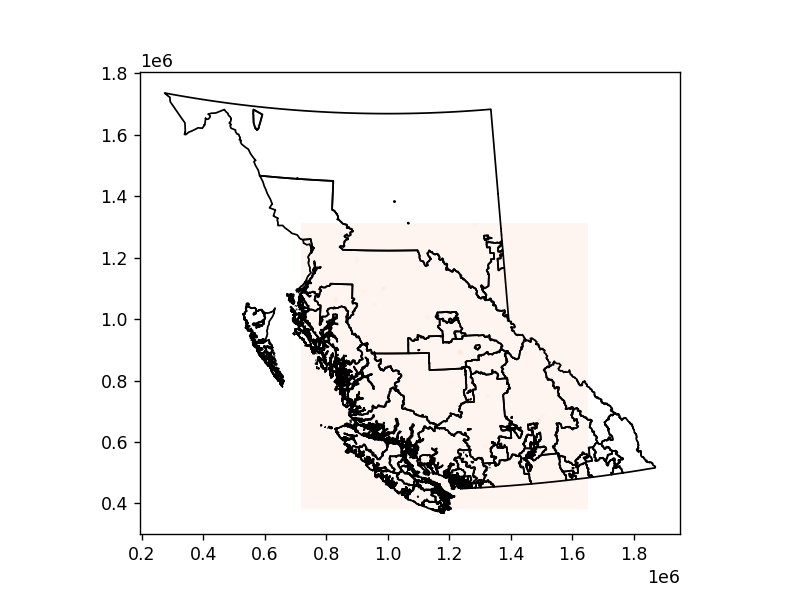

In [57]:

from rasterio.plot import show
fig,ax=plt.subplots()
with rio.open('Kernel_Density.tif','r') as Test:
    show(Test,ax=ax,cmap='Reds')
    
BC_FSA.plot(ax=ax,facecolor='None',edgecolor='k')
    
    
# ## Set Zoom & Turn Grid off
x = 1.222e6
y = 0.47e6

Size = 4e4
v = Size/2
h = Size/2